# Depression Speech Detection Pipeline

In [ ]:
!pip install TTS

In [ ]:
# 1. Setup & Imports
import os
import numpy as np
import requests
import wave
import base64
import time
import joblib
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from TTS.api import TTS


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Feature Extraction
import os # Import the os module here
import librosa # Import librosa here
import numpy as np
from sklearn.model_selection import train_test_split


def extract_mel_spectrogram(file_path, n_mels=128, time_steps=128):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    # Pad/crop to fixed size
    if S_db.shape[1] < time_steps:
        S_db = np.pad(S_db, ((0,0),(0,time_steps-S_db.shape[1])), mode='constant')
    else:
        S_db = S_db[:, :time_steps]
    return S_db

# Modified to yield features and labels
def process_folder_batch(folder_path, label, batch_size=10):
    features_batch, labels_batch, base_names_batch = [], [], []
    for i, file in enumerate(os.listdir(folder_path)):
        if file.endswith(".wav"):
            file_path = os.path.join(folder_path, file)
            try:
                feature = extract_mel_spectrogram(file_path)
                features_batch.append(feature)
                labels_batch.append(label)
                base_names_batch.append(os.path.splitext(file)[0])
                if (i + 1) % batch_size == 0:
                    yield features_batch, labels_batch, base_names_batch
                    features_batch, labels_batch, base_names_batch = [], [], []
            except Exception as e:
                print(f"Skipping {file}: {e}")
    # Yield any remaining features
    if features_batch:
        yield features_batch, labels_batch, base_names_batch


depressed_folder = "/content/drive/MyDrive/speech_depression/depressed"
healthy_folder = "/content/drive/MyDrive/speech_depression/healthy"

# Process and save features in batches
all_features, all_labels, all_base_names = [], [], []
for folder, label in [(depressed_folder, 1), (healthy_folder, 0)]:
    for f_batch, l_batch, b_batch in process_folder_batch(folder, label):
        all_features.extend([x.flatten() for x in f_batch])
        all_labels.extend(l_batch)
        all_base_names.extend(b_batch)

print(f"features: {len(all_features)}, labels: {len(all_labels)}, base_names: {len(all_base_names)}")

# Split into train/test
X_train, X_test, y_train, y_test, train_names, test_names = train_test_split(
    all_features, all_labels, all_base_names, test_size=0.4, random_state=42, stratify=all_labels # Changed test_size to 0.4
)

with open("train_files.txt", "w") as f:
    for name in train_names:
        f.write(f"{name}\n")

np.save("X_train.npy", np.array(X_train))
np.save("X_test.npy", np.array(X_test))
np.save("y_train.npy", np.array(y_train))
np.save("y_test.npy", np.array(y_test))

features: 43, labels: 43, base_names: 43


In [ ]:
!pip install openai-whisper

In [ ]:
import os
from google.cloud import speech_v1p1beta1 as speech

# Replace with the path to your service account key file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/axial-module-463314-s3-4d1ad567dfc4.json' # Make sure this is the correct path

def transcribe_audio(audio_file_path):
    """Transcribes the audio file using Google Cloud Speech-to-Text."""
    # ... (rest of the transcribe_audio function remains the same)
    client = speech.SpeechClient()

    with open(audio_file_path, "rb") as audio_file:
        content = audio_file.read()

    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16, # Adjust based on your audio file's encoding
        sample_rate_hertz=16000, # Adjust based on your audio file's sample rate
        language_code="en-US", # Adjust based on the language in your audio
    )

    print(f"Waiting for operation to complete for {audio_file_path}...")
    response = client.recognize(config=config, audio=audio)

    transcript = ""
    for result in response.results:
        transcript += result.alternatives[0].transcript

    return transcript

# --- Modified part to process multiple files ---
audio_folders = ["/content/drive/MyDrive/speech_depression/healthy", "/content/drive/MyDrive/speech_depression/depressed"]

for audio_folder in audio_folders:
    transcription_folder = os.path.join(audio_folder, "transcriptions")
    os.makedirs(transcription_folder, exist_ok=True) # Create transcriptions folder

    for fname in os.listdir(audio_folder):
        if fname.endswith(".wav"):
            audio_path = os.path.join(audio_folder, fname)
            try:
                transcribed_text = transcribe_audio(audio_path)
                # Save the transcript to a file
                transcript_path = os.path.join(transcription_folder, os.path.splitext(fname)[0] + ".txt")
                with open(transcript_path, "w") as f:
                    f.write(transcribed_text)
                print(f"Transcription saved for {fname} in {transcription_folder}")
            except Exception as e:
                print(f"An error occurred transcribing {fname}: {e}")

Waiting for operation to complete for /content/drive/MyDrive/speech_depression/healthy/MERSA_196_01_001.wav...
Transcription saved for MERSA_196_01_001.wav in /content/drive/MyDrive/speech_depression/healthy/transcriptions
Waiting for operation to complete for /content/drive/MyDrive/speech_depression/healthy/MERSA_205_01_001.wav...
Transcription saved for MERSA_205_01_001.wav in /content/drive/MyDrive/speech_depression/healthy/transcriptions
Waiting for operation to complete for /content/drive/MyDrive/speech_depression/healthy/MERSA_244_01_001.wav...
Transcription saved for MERSA_244_01_001.wav in /content/drive/MyDrive/speech_depression/healthy/transcriptions
Waiting for operation to complete for /content/drive/MyDrive/speech_depression/healthy/MERSA_208_01_001.wav...
Transcription saved for MERSA_208_01_001.wav in /content/drive/MyDrive/speech_depression/healthy/transcriptions
Waiting for operation to complete for /content/drive/MyDrive/speech_depression/healthy/MERSA_252_01_001.wav.

In [ ]:
# 4. Synthetic Audio Generation (Coqui TTS) - Re-added

# Define folders for Coqui synthetic audio output
coqui_folders = [
    {
        "label": "healthy",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "synthetic_audio_coqui")
    },
    {
        "label": "depressed",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "synthetic_audio_coqui")
    }
]

# Initialize the Coqui TTS model
# You can explore available models using TTS().list_models()
# Choosing a common English model for demonstration
coqui_tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", progress_bar=False, gpu=False)


for folder in coqui_folders:
    transcription_folder = folder["transcription_folder"]
    coqui_synthetic_audio_folder = folder["synthetic_audio_folder"]
    os.makedirs(coqui_synthetic_audio_folder, exist_ok=True)

    for txt_file in os.listdir(transcription_folder):
        base_name = os.path.splitext(txt_file)[0]
        txt_path = os.path.join(transcription_folder, txt_file)
        output_wav = os.path.join(coqui_synthetic_audio_folder, base_name + "_coqui.wav")

        # Check if the output file already exists and skip if it does
        if os.path.exists(output_wav):
            print(f"Coqui synthetic audio already exists, skipping: {output_wav}")
            continue

        with open(txt_path, "r") as f:
            text = f.read().strip()

        try:
            # Use the initialized Coqui TTS model to generate speech
            coqui_tts.tts_to_file(text=text, file_path=output_wav)
            print(f"Coqui synthetic audio saved: {output_wav}")
        except Exception as e:
            print(f"Error generating Coqui audio for {txt_file}: {e}")

 > tts_models/en/ljspeech/tacotron2-DDC is already downloaded.
 > vocoder_models/en/ljspeech/hifigan_v2 is already downloaded.
 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Model's reduction rate `r` is set to: 1
 > Vocoder Model: hifigan
 > Setting up Audio P

In [ ]:
# 4. Synthetic Audio Generation (HuggingFace only)
folders = [
    {
        "label": "healthy",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "synthetic_audio_hf") # Changed to hf folder
    },
    {
        "label": "depressed",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "synthetic_audio_hf") # Changed to hf folder
    }
]

# HuggingFace TTS
hf_tts = TTS(model_name="tts_models/en/ljspeech/tacotron2-DDC", progress_bar=False, gpu=False)
for folder in folders:
    transcription_folder = folder["transcription_folder"]
    hf_synthetic_audio_folder = folder["synthetic_audio_folder"] # Use the updated folder path
    os.makedirs(hf_synthetic_audio_folder, exist_ok=True)
    for txt_file in os.listdir(transcription_folder):
        base_name = os.path.splitext(txt_file)[0]
        txt_path = os.path.join(transcription_folder, txt_file)
        output_wav = os.path.join(hf_synthetic_audio_folder, base_name + "_hf.wav")
        if os.path.exists(output_wav):
            continue
        with open(txt_path, "r") as f:
            text = f.read().strip()
        try:
            hf_tts.tts_to_file(text=text, file_path=output_wav)
            print(f"HuggingFace synthetic audio saved: {output_wav}")
        except Exception as e:
            print(f"Error generating HuggingFace audio for {txt_file}: {e}")

In [ ]:
# 5. Feature Extraction for Synthetic Audio (HuggingFace only)
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split


def extract_mel_spectrogram(file_path, n_mels=128, time_steps=128):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    # Pad/crop to fixed size
    if S_db.shape[1] < time_steps:
        S_db = np.pad(S_db, ((0,0),(0,time_steps-S_db.shape[1])), mode='constant')
    else:
        S_db = S_db[:, :time_steps]
    return S_db


def extract_synthetic_features_hf(folders):
    features, labels, names = [], [], []
    for folder in folders:
        hf_synthetic_audio_folder = folder["synthetic_audio_folder"] # Use the updated folder path
        if not os.path.exists(hf_synthetic_audio_folder):
            continue
        for fname in os.listdir(hf_synthetic_audio_folder):
            if fname.endswith("_hf.wav"):
                file_path = os.path.join(hf_synthetic_audio_folder, fname)
                try:
                    feat = extract_mel_spectrogram(file_path)
                    features.append(feat.flatten())
                    labels.append(0 if folder["label"] == "healthy" else 1)
                    names.append(os.path.splitext(fname)[0])
                except Exception as e:
                    print(f"Skipping {fname}: {e}")
    return np.array(features), np.array(labels), names

folders = [
    {
        "label": "healthy",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "synthetic_audio_hf")
    },
    {
        "label": "depressed",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "synthetic_audio_hf")
    }
]

X_hf, y_hf, hf_filenames = extract_synthetic_features_hf(folders)
with open("hf_filenames.txt", "w") as f:
    for name in hf_filenames:
        f.write(name + "\n")

# Save the features and labels for synthetic audio
np.save("X_hf.npy", X_hf)
np.save("y_hf.npy", y_hf)

In [ ]:
# 5. Feature Extraction for Synthetic Audio (Coqui only)
import os
import numpy as np
import librosa

def extract_mel_spectrogram(file_path, n_mels=128, time_steps=128):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    # Pad/crop to fixed size
    if S_db.shape[1] < time_steps:
        S_db = np.pad(S_db, ((0,0),(0,time_steps-S_db.shape[1])), mode='constant')
    else:
        S_db = S_db[:, :time_steps]
    return S_db

def extract_synthetic_features_coqui(folders):
    features, labels, names = [], [], []
    for folder in folders:
        coqui_synthetic_audio_folder = folder["synthetic_audio_folder"]
        if not os.path.exists(coqui_synthetic_audio_folder):
            continue
        for fname in os.listdir(coqui_synthetic_audio_folder):
            if fname.endswith("_coqui.wav"):
                file_path = os.path.join(coqui_synthetic_audio_folder, fname)
                try:
                    feat = extract_mel_spectrogram(file_path)
                    features.append(feat.flatten())
                    labels.append(0 if folder["label"] == "healthy" else 1)
                    names.append(os.path.splitext(fname)[0])
                except Exception as e:
                    print(f"Skipping {fname}: {e}")
    return np.array(features), np.array(labels), names

coqui_folders = [
    {
        "label": "healthy",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/healthy", "synthetic_audio_coqui")
    },
    {
        "label": "depressed",
        "transcription_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "transcriptions"),
        "synthetic_audio_folder": os.path.join("/content/drive/MyDrive/speech_depression/depressed", "synthetic_audio_coqui")
    }
]

X_coqui, y_coqui, coqui_filenames = extract_synthetic_features_coqui(coqui_folders)
with open("coqui_filenames.txt", "w") as f:
    for name in coqui_filenames:
        f.write(name + "\n")

# Save the features and labels for synthetic audio
np.save("X_coqui.npy", X_coqui)
np.save("y_coqui.npy", y_coqui)

=== Model Performance Under Different Training Conditions ===

Real audio only
Accuracy: 0.61
F1-score: 0.59
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.60      0.38      0.46         8

    accuracy                           0.61        18
   macro avg       0.61      0.59      0.58        18
weighted avg       0.61      0.61      0.59        18



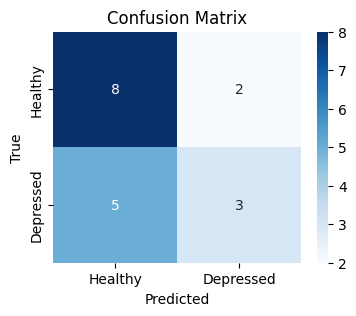


Real + HuggingFace synthetic
Accuracy: 0.61
F1-score: 0.61
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.57      0.50      0.53         8

    accuracy                           0.61        18
   macro avg       0.60      0.60      0.60        18
weighted avg       0.61      0.61      0.61        18



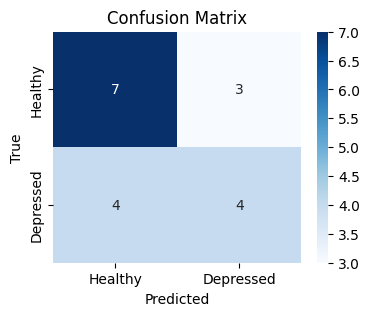


Real + Coqui synthetic
Accuracy: 0.50
F1-score: 0.44
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.80      0.64        10
           1       0.33      0.12      0.18         8

    accuracy                           0.50        18
   macro avg       0.43      0.46      0.41        18
weighted avg       0.44      0.50      0.44        18



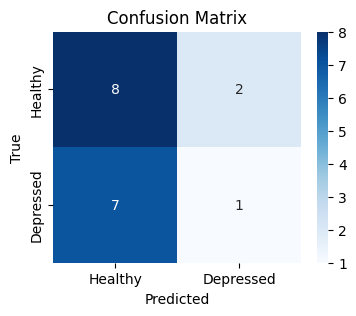


=== LaTeX Table for Performance Comparison ===

\begin{table*}[ht]
\centering
\caption{Comparison of Model Performance with Different Training Data}
\label{tab:performance_comparison}
\begin{tabular}{|l|c|c|}
\hline
\textbf{Training Data Scenario} & \textbf{Accuracy} & \textbf{F1-score} \\
\hline
Real audio only & 0.61 & 0.59 \\
Real + HuggingFace synthetic & 0.61 & 0.61 \\
Real + Coqui synthetic & 0.50 & 0.44 \\
\hline
\end{tabular}
\end{table*}



In [ ]:
# 6. Model Training & Evaluation and Comparison Table
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_real = np.load("X_train.npy")
y_real = np.load("y_train.npy")
X_test_real = np.load("X_test.npy")
y_test_real = np.load("y_test.npy")

# Load HuggingFace synthetic features
X_hf = np.load("X_hf.npy", allow_pickle=True)
y_hf = np.load("y_hf.npy", allow_pickle=True)

# Load Coqui synthetic features
X_coqui = np.load("X_coqui.npy", allow_pickle=True)
y_coqui = np.load("y_coqui.npy", allow_pickle=True)


scenarios = [
    ("Real audio only", X_real, y_real),
    ("Real + HuggingFace synthetic", np.concatenate([X_real, X_hf]), np.concatenate([y_real, y_hf])),
    ("Real + Coqui synthetic", np.concatenate([X_real, X_coqui]), np.concatenate([y_real, y_coqui])),
]

results = []

print("=== Model Performance Under Different Training Conditions ===")
for label, X_train, y_train in scenarios:
    if len(np.unique(y_train)) < 2:
        print(f"\n{label} - Skipped: Only one class present in training data.")
        continue
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_real)
    acc = accuracy_score(y_test_real, y_pred)
    f1 = f1_score(y_test_real, y_pred, average="weighted")
    print(f"\n{label}")
    print(f"Accuracy: {acc:.2f}\nF1-score: {f1:.2f}")
    print("Classification Report:")
    print(classification_report(y_test_real, y_pred, digits=2))
    cm = confusion_matrix(y_test_real, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Depressed"], yticklabels=["Healthy", "Depressed"])
    plt.title(f"Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    results.append({"Scenario": label, "Accuracy": acc, "F1-score": f1})

# Generate LaTeX table
latex_table = """
\\begin{table*}[ht]
\\centering
\\caption{Comparison of Model Performance with Different Training Data}
\\label{tab:performance_comparison}
\\begin{tabular}{|l|c|c|}
\\hline
\\textbf{Training Data Scenario} & \\textbf{Accuracy} & \\textbf{F1-score} \\\\
\\hline
"""

for result in results:
    latex_table += f"{result['Scenario']} & {result['Accuracy']:.2f} & {result['F1-score']:.2f} \\\\\n"

latex_table += """\\hline
\\end{tabular}
\\end{table*}
"""

print("\n=== LaTeX Table for Performance Comparison ===")
print(latex_table)

In [ ]:
!pip install whisper

In [ ]:
try:
    import openai_whisper
    print("openai_whisper is installed and can be imported.")
    print(f"Location: {openai_whisper.__file__}")
except ModuleNotFoundError:
    print("openai_whisper is not installed or cannot be imported.")

In [ ]:
# Install openai-whisper
!pip install openai-whisper

# 3. Transcription (Whisper)
import openai_whisper
import os

audio_folders = ["/content/drive/MyDrive/speech_depression/healthy", "/content/drive/MyDrive/speech_depression/depressed"]
model = openai_whisper.load_model("base")

for audio_folder in audio_folders:
    transcription_folder = os.path.join(audio_folder, "transcriptions")
    os.makedirs(transcription_folder, exist_ok=True)
    for fname in os.listdir(audio_folder):
        if fname.endswith(".wav"):
            audio_path = os.path.join(audio_folder, fname)
            try:
                result = model.transcribe(audio_path)
                transcript = result["text"]
                transcript_path = os.path.join(transcription_folder, os.path.splitext(fname)[0] + ".txt")
                with open(transcript_path, "w") as f:
                    f.write(transcript)
                print(f"Transcript saved for {fname} in {transcription_folder}")
            except Exception as e:
                print(f"Error transcribing {fname}: {e}")

In [ ]:
import sys
print(sys.path)

In [ ]:
!pip install google-cloud-speech

# Task
Transcribe audio files from "/content/drive/MyDrive/speech_depression/healthy" and "/content/drive/MyDrive/speech_depression/depressed" using Google Cloud Speech-to-Text, extract features from both original and synthetic audio, train a depression detection model, and evaluate its performance.

## Address ram limitations

### Subtask:
Modify data loading and processing to handle data in smaller batches or use memory-efficient techniques.


**Reasoning**:
Review the existing code for data loading and feature extraction to identify areas for optimization.



In [ ]:
# Review of existing code
# The functions `extract_mel_spectrogram` and `process_folder` are responsible for loading and processing audio data.
# `process_folder` reads all .wav files in a folder, extracts features for each, and appends them to lists.
# This can lead to high memory usage for large datasets as all features are held in memory simultaneously.
# The features are then flattened and saved to .npy files, which is a good step, but the in-memory accumulation can still be an issue.

# Modification strategy:
# 1. Modify `process_folder` to yield features and labels for each file instead of returning lists.
# 2. Modify the main loop that calls `process_folder` to process and save features in batches.

# Task
Re-add the Coqui TTS code to the notebook, generate synthetic audio using Coqui TTS, extract features from the Coqui synthetic audio, train and evaluate the model including the Coqui synthetic data, and create a LaTeX table comparing the results (Accuracy and F1-score) of the model trained with real data only, real + Hugging Face synthetic data, and real + Coqui synthetic data.

## Generate synthetic audio (coqui)

### Subtask:
Add code to generate synthetic audio using Coqui TTS based on the transcriptions.


**Reasoning**:
Add code to generate synthetic audio using Coqui TTS based on the transcriptions.

